In [1]:
from __future__ import division, print_function
%matplotlib inline

from glob import glob
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import progressbar as pb
import seaborn as sns
from scipy.stats.mstats import mquantiles

In [2]:
problem = 'blobs'
arg_prefix = 'rat'
level = .1

In [3]:
basedir = os.path.join('res_fixed', problem)
to_read = []
for fn in glob(os.path.join(basedir, '{}*'.format(arg_prefix), 'n*.h5')):
    arg, base = os.path.relpath(fn, basedir).split('/')
    arg = arg[len(arg_prefix):]
    try:
        arg = int(arg)
    except ValueError:
        try:
            arg = float(arg)
        except ValueError:
            pass
    n = int(base[1:-3])
    to_read.append((arg, n, fn))

In [4]:
methods = [
    ('mmd', lambda d: d.mmd_est),
    ('t', lambda d: d.mmd_est / np.sqrt(d.var_est)),
    ('tau', lambda d: (d.mmd_est - _get_thresh(d) / n) / np.sqrt(d.var_est)),
]

In [5]:
def _get_thresh(d):
    if 'thresh_{}'.format(level) in d:
        return d['thresh_{}'.format(level)]
    elif 'samps' in d:
        if d.samps.dtype != np.float32:
            d['samps'] = d.samps.map(lambda x: np.fromstring(x, dtype=np.float32))
        return d.samps.map(lambda s: mquantiles(s, prob=1 - level)[0])
    else:
        raise ValueError("Sorry, can't do level {}. Could do any of {}".format(
            level, ', '.join(str(float(k[len('thresh_'):]))
                             for k in d if k.startswith('thresh_'))))

In [6]:
info_cols = (['problem_arg', 'n', 'best_power']
             + ['{}_mean_power'.format(m) for m, f in methods]
             + ['{}_std_power'.format(m) for m, f in methods])
    
info = []
for i, (r, n, fn) in enumerate(to_read):
    print('\r{} / {}'.format(i, len(to_read)), end='', file=sys.stderr)
    d = pd.read_hdf(fn)
    power = d.groupby(level='sigma').p.agg(lambda x: (x <= level).mean())
    
    for m, f in methods:
        d[m] = f(d)
    
    max_powers = d[[m for m, f in methods]].groupby(level='rep').agg(
        lambda x: power.loc[x.idxmax()[0]])
    means = max_powers.apply(np.mean)
    stds = max_powers.apply(np.std)
    info.append((r, n, power.max()) + tuple(means) + tuple(stds))
print('\r' + ' ' * 20, file=sys.stderr)

info = pd.DataFrame(info, columns=info_cols)
info.set_index(['problem_arg', 'n'], inplace=True)
info.sortlevel(inplace=True)

In [7]:
def plot_errorbar(s, legend_loc='best'):
    xs = np.asarray(s.index.get_level_values(0))
    dist = np.diff(xs).min()
    for i, (k, _) in enumerate(methods):
        plt.errorbar(xs + (i-1) * dist / 30,
                     np.asarray(s['{}_mean_power'.format(k)]),
                     np.asarray(s['{}_std_power'.format(k)]),
                     label=k)
    plt.plot(xs, s.best_power, color='k', ls='--', label='best choice')
    plt.legend(loc=legend_loc)
    plt.ylabel('Rejection rate')

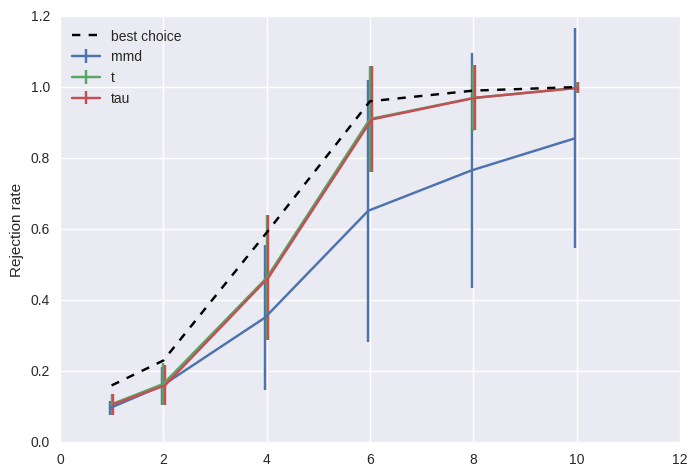

In [8]:
plot_errorbar(info.xs(500, level='n'))